# Readme
Tут два файла истории EURUSD 1 за 2016 год часовой тик. 2016й полньій год можна использовать для обучения, а часть 2017-го для валидации, я включил 2.5 месяца в 2017й.

Данньіе в файлах идут как Local time, Open,High, Low,Close, Volume

Не знаю насколько тьі знаком с такими данньіми. Коротко, то Open - цена в начале тика данньіх, Close - в конце периода, ну и High Low внутренние колебания наибольшая и наименьшая цена
В принципе все 4, и также Volume, обьем продаж за етот период, важньі. Но для простотьі можем пока что брать только Open цену для обучального набора примеров

Тут Gnuplot скрипт для примера чтобьі рисовать Candlesticks и етих данньіх

Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее
Таким образом learning set будет иметь 8754 примера

# Contents:
## [Useful links](#Links)

## [Data Wrangling](#DWr)
- Import packages and read the data
- [Plot the data](#PlotData)

## [ARIMA based model](#ARIMA) (In progress)
- Split input data into [batches](#Batches) (learning windows)
- Explanation of [SARIMAX](#SARIMAX)
- Fast [Bayesian estimation](#BSARIMAX) of SARIMAX models

## Combine [LSTM and ARIMA](#LSTM+ARIMA) (TODO)

===================================================================================================================

## Useful links<a id='Links'></a>
- [Chapter 9 **ARIMA models**](https://otexts.com/fpp3/arima.html) from the book "Forecasting: Principles and Practice (3rd ed)", *Rob J **Hyndman** and George Athanasopoulos*, Monash University, Australia
- [statsmodels.org](https://www.statsmodels.org/stable/index.html) python package that includes models for time series analysis.
- [**Time Series Forecasting — ARIMA, LSTM, Prophet with Python**](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887) from [Caner Dabakoglu](https://medium.com/@cdabakoglu) at https://medium.com/
- [The Secret Betting Strategy That Beats Online Bookmakers](https://www.technologyreview.com/2017/10/19/67760/the-secret-betting-strategy-that-beats-online-bookmakers/) from [MIT Technology Review](https://www.technologyreview.com/)
     - the source: "Beating the bookies with their own numbers - and how the online sports betting market is rigged", see [arxiv](https://arxiv.org/abs/1710.02824).

## Data Wrangling<a id='DWr'></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Read the input files
# Select short names in order to not retype the same stuff. 
df      = pd.read_table('EURUSD_1H_2016.txt',sep=',')
df_long = pd.read_table('EURUSD_1H_2005_2016.txt',sep=',')

In [3]:
# Preview the dataframe
df

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
...,...,...,...,...,...,...
8778,31.12.2016 19:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8779,31.12.2016 20:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8780,31.12.2016 21:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8781,31.12.2016 22:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0


In [4]:
# Check for nan values 
df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [5]:
# Check type
type(df)

pandas.core.frame.DataFrame

In [6]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null object
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [7]:
# Check info
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97837 entries, 0 to 97836
Data columns (total 6 columns):
Local time    97837 non-null object
Open          97837 non-null float64
High          97837 non-null float64
Low           97837 non-null float64
Close         97837 non-null float64
Volume        97837 non-null float64
dtypes: float64(5), object(1)
memory usage: 4.5+ MB


### Plot the data<a id='PlotData'></a>

In [8]:
# Plot everything as a line
df.plot.line();
# Plot in log scale
df.plot.line(logy=True);

**`Volume` is much larger than anything else.**

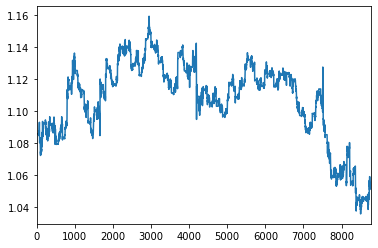

In [9]:
# Plot only 'Open'
df.Open.plot.line();

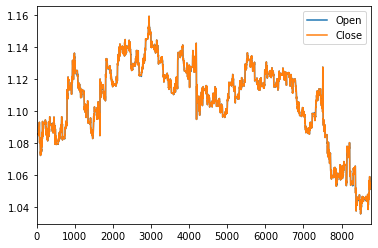

In [10]:
# Plot 'Open' and 'Close'
df.plot.line(y={'Open','Close'});

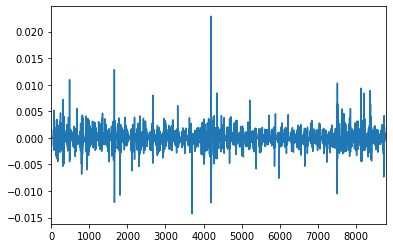

In [11]:
# Plot the difference of 'Open' and 'Close'
(df.Open - df.Close).plot.line();

**`Open` almost coincides with `Close`.**

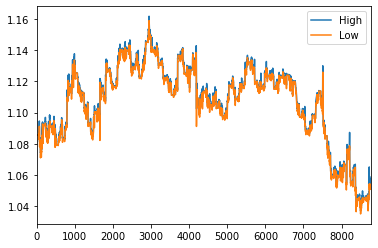

In [12]:
# Plot 'High' and 'Low'
df.plot.line(y={'High','Low'});

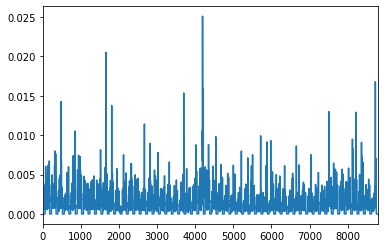

In [13]:
# Plot the difference of 'High' and 'Low'
(df.High - df.Low).plot.line();

## Formlate the ML Model<a id='Model'></a>

### Split input data into batches (learning windows)<a id='Batches'></a>

In [14]:
# Get 'Open'
df.Open

0       1.08564
1       1.08564
2       1.08564
3       1.08564
4       1.08564
         ...   
8778    1.05150
8779    1.05150
8780    1.05150
8781    1.05150
8782    1.05150
Name: Open, Length: 8783, dtype: float64

In [15]:
# Get 'Open' by index
print('Open[0]:\n',df.Open[0])
print('Open[8782]:\n',df.Open[8782])
# Get a slice
print('Open[100:110]:\n',df.Open[100:110])

Open[0]:
 1.08564
Open[8782]:
 1.0515
Open[100:110]:
 100    1.07559
101    1.07516
102    1.07421
103    1.07391
104    1.07216
105    1.07422
106    1.07455
107    1.07338
108    1.07436
109    1.07500
Name: Open, dtype: float64


In [16]:
# Можна например разбить данньіе на бегущее окно 24 Open price для входа в сеть, 
# и скажем 5 последующих для вьіхода сети, т.е. предсказание на 5 тиков в будущее.
# Таким образом learning set будет иметь 8754 примера
def get_slices(data, point, run_win=24, fwd_win=5):
    
    # Input:
        # data: a column in a data frame to slice,
        # point: index of the entering point for the slice, 
        # run_win: backward looking window,
        # fwd_win: forward looking window
        
    # Output:
        # run: backward slice
        # fwd: forward slice
    start = point - run_win 
    stop  = point + fwd_win
    
    run = data[start:point+1]
    fwd = data[      point+1:stop+1]
    
    return run, fwd

In [17]:
# Test `get_slices`
data = df
get_slices(data,42,fwd_win=3)

(                 Local time     Open     High      Low    Close  Volume
 18  01.01.2016 18:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 19  01.01.2016 19:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 20  01.01.2016 20:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 21  01.01.2016 21:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 22  01.01.2016 22:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 23  01.01.2016 23:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 24  02.01.2016 00:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 25  02.01.2016 01:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 26  02.01.2016 02:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 27  02.01.2016 03:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 28  02.01.2016 04:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 29  02.01.2016 05:00:00.000  1.08564  1.08564  1.08564  1.08564     0.0
 30  02.01.2016 06:00:00.000  1.08564  1.08564  1.0

### Make a standard ARIMA based model<a id='ARIMA'></a>
We adapt the model formulated [here](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887).

In [18]:
# Install pmdarima https://anaconda.org/saravji/pmdarima
# From jupyter notebook, sending "yes", if required
#! conda install -c saravji pmdarima --y

In [19]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
#warnings.filterwarnings("ignore")

/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


**(!) One needs to make sure that the Panda Series object has a DateTime index with inferred frequency, see [this](https://stackoverflow.com/questions/64025453/attributeerror-rangeindex-object-has-no-attribute-inferred-freq).** 

In [20]:
# Read the dataframe again, in order to be sure that nothing happened to it in previous cells.
df = pd.read_table('EURUSD_1H_2016.txt',sep=',')
df

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
...,...,...,...,...,...,...
8778,31.12.2016 19:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8779,31.12.2016 20:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8780,31.12.2016 21:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0
8781,31.12.2016 22:00:00.000,1.05150,1.05150,1.05150,1.05150,0.0


In [21]:
# Check whether Local time is of index type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null object
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


**Our indexes are just numbers => convert the column `Local time` to index, see [this](https://stackoverflow.com/questions/37610983/how-set-column-as-date-index).**

In [22]:
# Convert to datetime
df['Local time'] = pd.to_datetime(df['Local time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
Local time    8783 non-null datetime64[ns]
Open          8783 non-null float64
High          8783 non-null float64
Low           8783 non-null float64
Close         8783 non-null float64
Volume        8783 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 411.8 KB


In [23]:
# Set the index
df.set_index('Local time', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 5 columns):
Open      8783 non-null float64
High      8783 non-null float64
Low       8783 non-null float64
Close     8783 non-null float64
Volume    8783 non-null float64
dtypes: float64(5)
memory usage: 411.7 KB


In [24]:
# Get "Close"
df_close = df["Close"]
df_close

Local time
2016-01-01 00:00:00    1.08564
2016-01-01 01:00:00    1.08564
2016-01-01 02:00:00    1.08564
2016-01-01 03:00:00    1.08564
2016-01-01 04:00:00    1.08564
                        ...   
2016-12-31 19:00:00    1.05150
2016-12-31 20:00:00    1.05150
2016-12-31 21:00:00    1.05150
2016-12-31 22:00:00    1.05150
2016-12-31 23:00:00    1.05150
Name: Close, Length: 8783, dtype: float64

#### **Get the best parameters for ARIMA.**
We use [pmdarima](https://pypi.org/project/pmdarima/) from [pypi.org](https://pypi.org) 

In [25]:
# Make a default fit
auto_arima(df_close).summary()

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-inver

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8783
Model:               SARIMAX(3, 1, 0)   Log Likelihood               47476.014
Date:                Thu, 18 Feb 2021   AIC                         -94942.028
Time:                        09:12:18   BIC                         -94906.626
Sample:                             0   HQIC                        -94929.967
                               - 8783                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.837e-06   1.18e-05     -0.325      0.745    -2.7e-05    1.93e-05
ar.L1          0.0389      0.004      9.963      0.000       0.031       0.047
ar.L2          0.0290      0.004      6.862      0.000       0.021       0.037
ar.L3         -0.0354      0.004     -8.497      0.000      -0.044      -0.027
sigma2       1.18e-06   3.95e-09    298.634      0.000    1.17e-06    1.19e-06
===================================================================================
Ljung-Box (Q):                       85.84   Jarque-Bera (JB):            747214.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**(!) The used model is SARIMAX.**

**Make a stepwise fit with the parameters from [the example](https://alkaline-ml.com/pmdarima/quickstart.html#quickstart) in the pmdarima**

In [50]:
stepwise_fit = auto_arima(df_close, 
                     start_p=1, start_q=1,
                     max_p=3, max_q=3, m=12,
                     start_P=0, seasonal=True,
                     d=1, D=1, trace=True,
                     error_action='ignore',  # don't want to know if an order does not work
                     suppress_warnings=True,  # don't want convergence warnings
                     stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-93673.529, BIC=-93638.134, Fit time=28.082 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-88584.214, BIC=-88570.056, Fit time=3.569 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-91139.735, BIC=-91111.419, Fit time=18.654 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-93669.699, BIC=-93641.383, Fit time=17.085 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-93662.423, BIC=-93619.949, Fit time=66.128 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-88607.103, BIC=-88578.787, Fit time=6.525 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-94165.541, BIC=-94123.066, Fit time=135.113 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-94158.977, BIC=-94123.581, Fit time=51.582 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-94141.193, BIC=-94091.639, Fit time

In [52]:
stepmise_fit.summary()

NameError: name 'stepmise_fit' is not defined

**(?) The fit did not work as expected?**

## **Fast Bayesian estimation of SARIMAX models**<a id='BSARIMAX'></a>
see the [example](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_pymc3.html) from statmodels.org.

**0. Install necessary packages.**

In [57]:
# Install theano, see https://anaconda.org/conda-forge/theano
!conda install -c conda-forge theano --y

Solving environment: done

# All requested packages already installed.



In [60]:
# Install pymc3, see https://anaconda.org/conda-forge/pymc3
!conda install -c conda-forge pymc3 --y

Solving environment: done

## Package Plan ##

  environment location: /home/vb/anaconda3

  added / updated specs:
    - pymc3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    arviz-0.11.1               |     pyhd8ed1ab_0         1.4 MB  conda-forge
    blosc-1.21.0               |       h9c3ff4c_0         841 KB  conda-forge
    cftime-1.4.1               |   py37h902c9e0_0         310 KB  conda-forge
    fastprogress-1.0.0         |             py_0          15 KB  conda-forge
    h5py-2.10.0                |nompi_py37h513d04c_102         1.2 MB  conda-forge
    hdf4-4.2.13                |    h10796ff_1004         951 KB  conda-forge
    hdf5-1.10.5                |nompi_h3c11f04_1104         3.1 MB  conda-forge
    jpeg-9d                    |       h36c2ea0_0         264 KB  conda-forge
    libgcc-ng-9.3

In [62]:
# Install pandas-datareader, see https://anaconda.org/anaconda/pandas-datareader
!conda install -c anaconda pandas-datareader --y

Solving environment: done

## Package Plan ##

  environment location: /home/vb/anaconda3

  added / updated specs:
    - pandas-datareader


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         128 KB  anaconda
    certifi-2020.6.20          |           py37_0         159 KB  anaconda
    openssl-1.1.1h             |       h7b6447c_0         3.8 MB  anaconda
    pandas-datareader-0.9.0    |             py_0          72 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following NEW packages will be INSTALLED:

  pandas-datareader  anaconda/noarch::pandas-datareader-0.9.0-py_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> anaconda::ca-certificates-2020.

**1. Import external dependencies**

In [63]:
%matplotlib inline
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()

In [64]:
# Create an SARIMAX model instance - here we use it to estimate
# the parameters via MLE using the `fit` method, but we can
# also re-use it below for the Bayesian estimation
mod = sm.tsa.statespace.SARIMAX(df_close, order=(3, 1, 0))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                 8783
Model:               SARIMAX(3, 1, 0)   Log Likelihood               47475.961
Date:                Thu, 18 Feb 2021   AIC                         -94943.923
Time:                        18:00:05   BIC                         -94915.601
Sample:                             0   HQIC                        -94934.274
                               - 8783                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0389      0.004      9.972      0.000       0.031       0.047
ar.L2          0.0290      0.004      6.872      0.000       0.021       0.037
ar.L3         -0.0354      0.004     -8.544      0.0

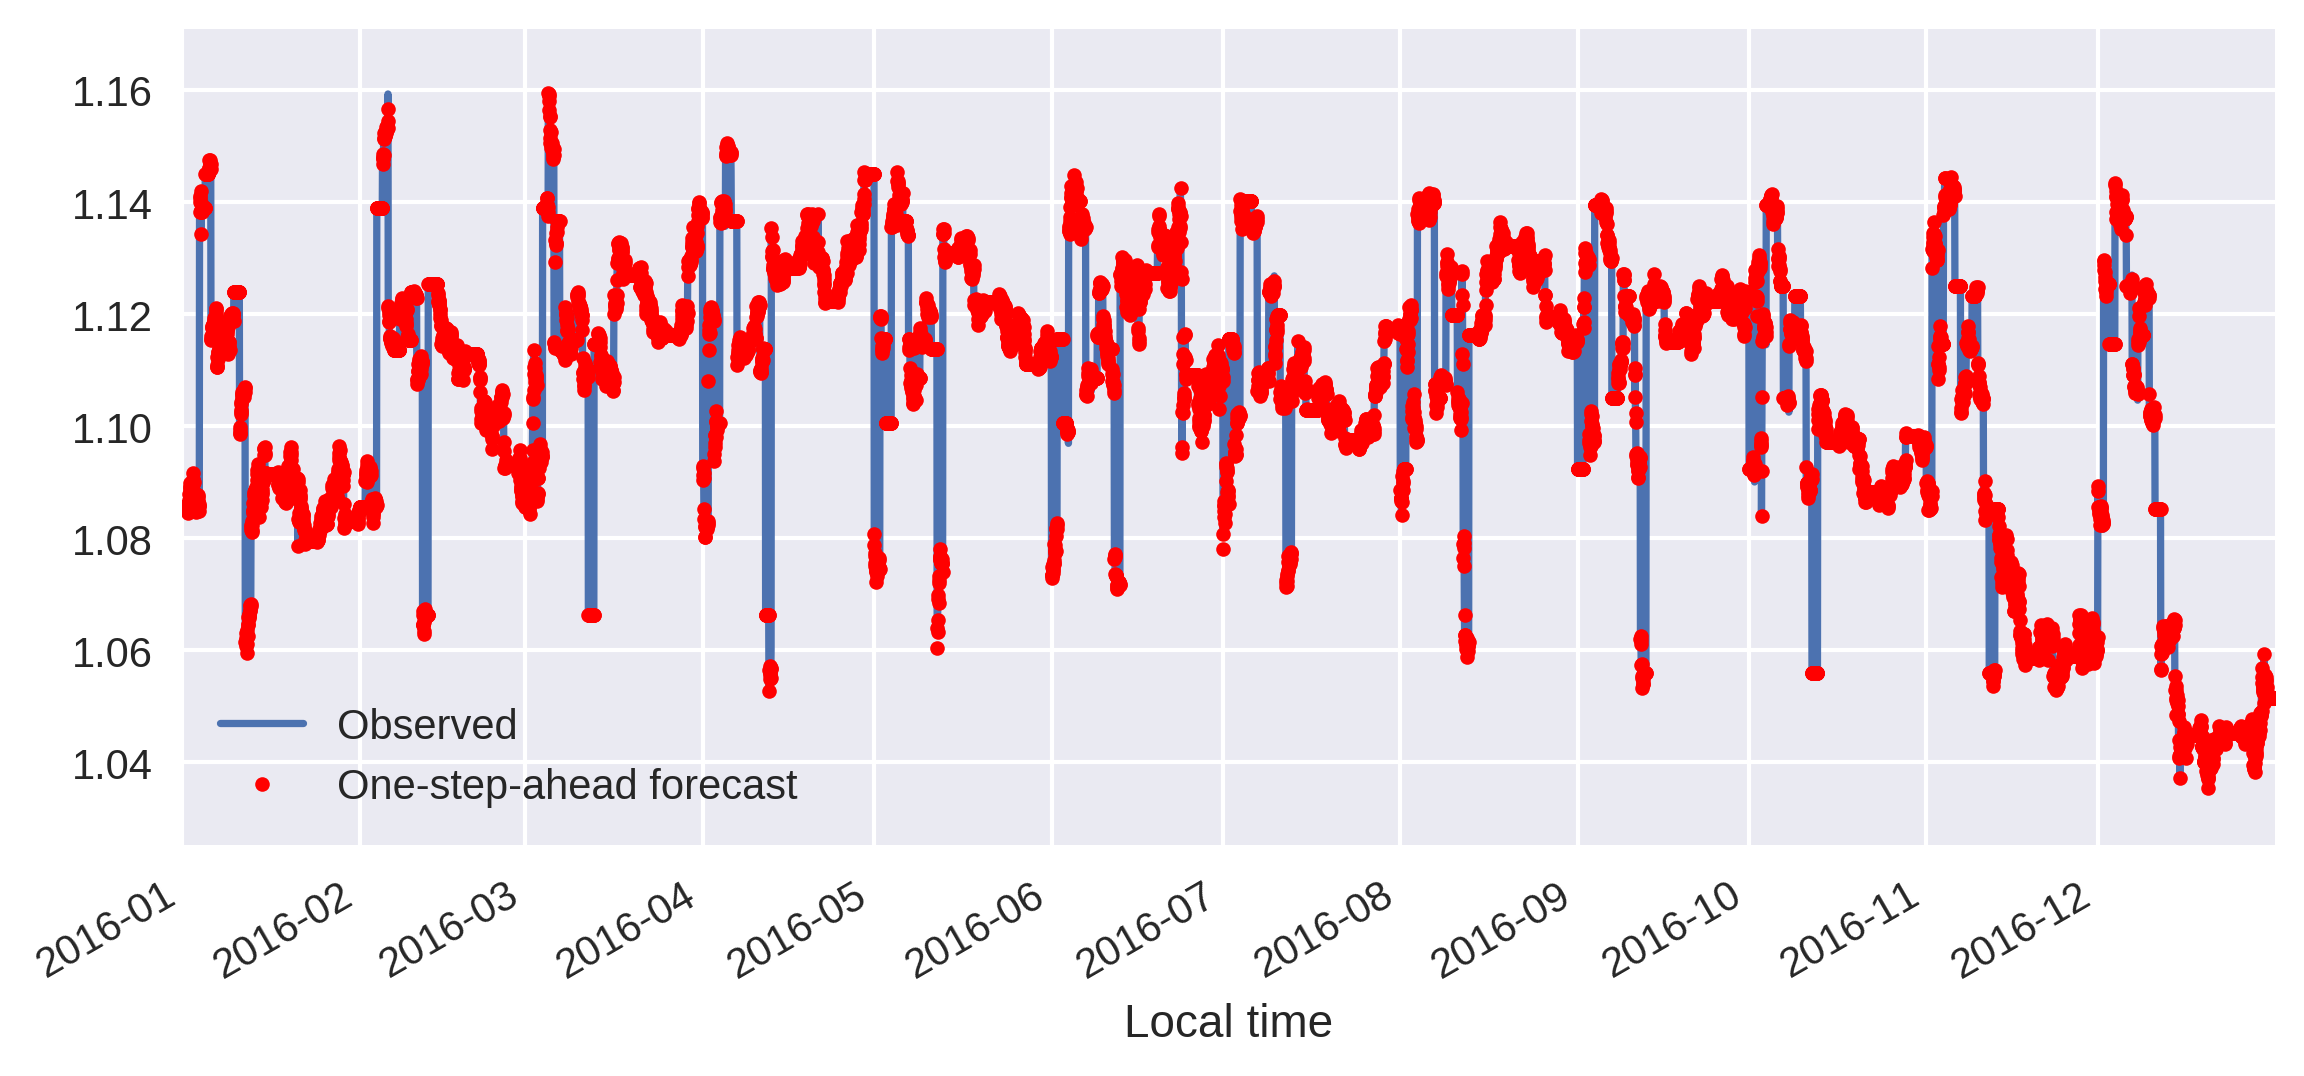

In [85]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower Close']
upper = predict_mle_ci['upper Close']

# Graph
fig, ax = plt.subplots(figsize=(9,4), dpi=300)

# Plot data points
df_close.plot(ax=ax, style='-', label='Observed')

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
#ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.legend(loc='lower left')
ax.set_ylim([df_close.min()*0.99,df_close.max()*1.01])
plt.show()

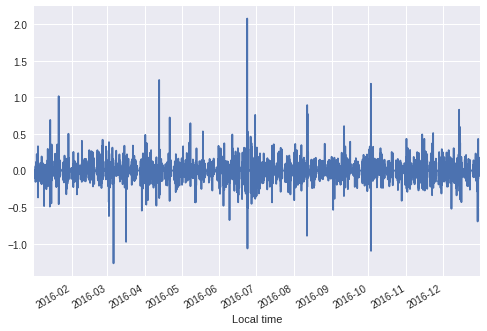

In [90]:
# Deviation of the prediction from the reality in percents
f1 = predict_mle.predicted_mean[1:]
f2 = df_close[1:]
dev = 100*(f1-f2)/f2
dev.plot();

### **Explanation of SARIMAX:**<a id='SARIMAX'></a>
We follow [Monthly Spot Price Prediction - Time Series Analysis by State Space Method.](https://towardsdatascience.com/monthly-spot-price-prediction-time-series-analysis-by-state-space-method-34aedf6ba294) from [towardsdatascience.com](https://towardsdatascience.com)
- SARIMAX is `S`easonal `A`uto`r`egressive `I`ntegrated `M`oving-`A`verage with e`X`ogenous regressors.
- Parameters: (p,d,q) (P,D,Q)S (X)
    - **p - non-seasonal autoregressive order**
    - **d - order of differencing**
    - q - non-seasonal moving average order
    - P - seasonal autoregressive order
    - D - order of seasonal differencing
    - Q - seasonal moving average order
    - S - seasonal length
    - X - vector of external variables
- The fitness of model is diagnosed using `Ljung-Box Q statistic` **(?)** to check the adequacy.
- We use the [SARIMAX model](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) implemented in [statsmodels.org](https://www.statsmodels.org/).

In [51]:
df_close

Local time
2016-01-01 00:00:00    1.08564
2016-01-01 01:00:00    1.08564
2016-01-01 02:00:00    1.08564
2016-01-01 03:00:00    1.08564
2016-01-01 04:00:00    1.08564
                        ...   
2016-12-31 19:00:00    1.05150
2016-12-31 20:00:00    1.05150
2016-12-31 21:00:00    1.05150
2016-12-31 22:00:00    1.05150
2016-12-31 23:00:00    1.05150
Name: Close, Length: 8783, dtype: float64

In [29]:
import matplotlib.pyplot as plt

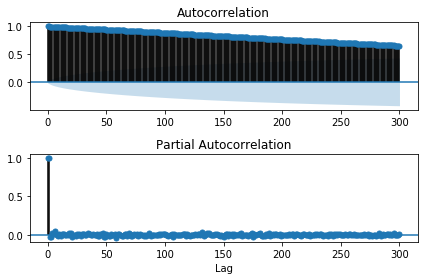

In [37]:
# Plot autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(df_close, ax=plt.gca(),lags=300)
plt.subplot(212)
plot_pacf(df_close, ax=plt.gca(),lags=300)
plt.xlabel('Lag')
plt.tight_layout()
plt.show()

**(!) The `non-seasonal autoregressive order` = order of correlation (the maximum lag), and in our data it is p = 1, see e.g. [wiki](https://en.wikipedia.org/wiki/Partial_autocorrelation_function).**

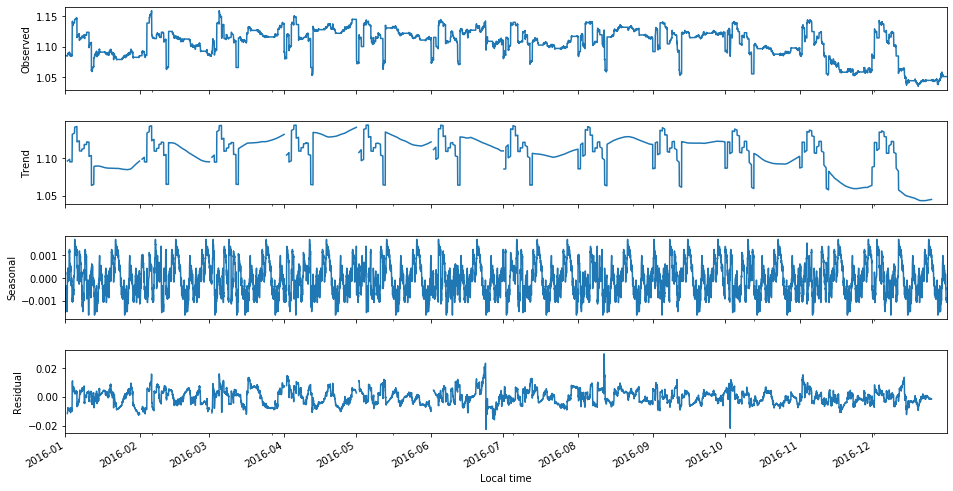

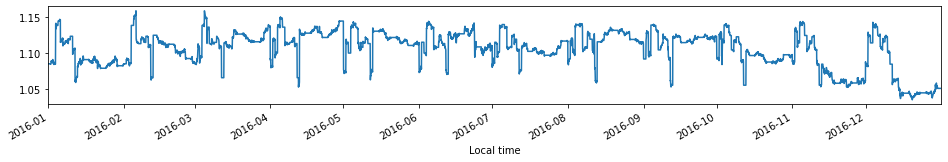

In [34]:
##Seasonal decompose
# Copy the dataframe in order to not change it
df_s = df_close.copy()
#df_s.set_index('Date', inplace=True)
#print(df_s.info())
df_s = df_s.astype(float)
#res = sm.tsa.seasonal_decompose(df['hh_sp'],freq=12)
res = seasonal_decompose(df_s,freq=300)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()
df_s.plot(figsize=(16,2));

**(?) What is seen in the Trend?**
- What is a regular repeating sctucture?
    - It appears once per month. Why?
    - Is it in the new data?
- Why we see such a trend only for `freq>100`?
    - what means `freq=100`?

### Use ADF/KPSS tests, see [statmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) 

In [47]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [45]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')#, nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [48]:
adf_test(df_close)

Results of Dickey-Fuller Test:
Test Statistic                   -1.427429
p-value                           0.569058
#Lags Used                       23.000000
Number of Observations Used    8759.000000
Critical Value (1%)              -3.431097
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566946
dtype: float64


**(!)** Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, **the series is non-stationary**.

In [46]:
kpss_test(df_close)

Results of KPSS Test:
Test Statistic            6.827678
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [92]:
type({})

dict

**Try [adfuller](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)** test from [towardsdatascience post](https://towardsdatascience.com/monthly-spot-price-prediction-time-series-analysis-by-state-space-method-34aedf6ba294) above, see explanation of the parameter meaning [here](https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results).

In [102]:
from statsmodels.tsa.stattools import adfuller
# Constant and trend order to include in regression.
reg = ["c","ct","ctt","nc"]
for r in reg:
    res = adfuller(df_close, regression=r)
    #print(res[1])
    print('trend: {}\t p-value: {}'.format(r,res[1]))

trend: c	 p-value: 0.5690581010758805
trend: ct	 p-value: 0.5022405149063209
trend: ctt	 p-value: 0.053278087572720685
trend: nc	 p-value: 0.5443137878747791


In [82]:
print(EURUSD_1H_2005_2016_df["Close"].index.freq)

None


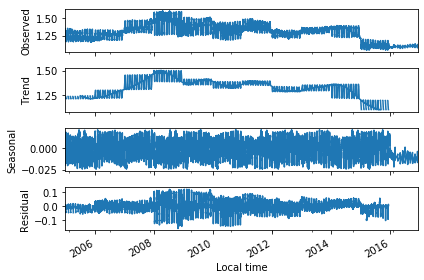

In [83]:
a = seasonal_decompose(EURUSD_1H_2005_2016_df["Close"], model = "add",freq=9000)
a.plot();

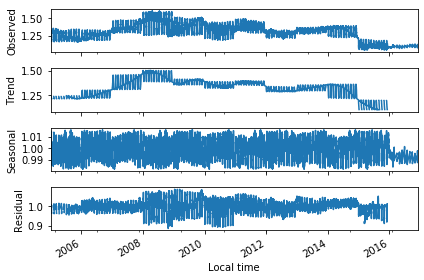

In [76]:
a = seasonal_decompose(EURUSD_1H_2005_2016_df["Close"], model = "mult",freq=9000)
a.plot();

In [6]:
auto_arima(df, seasonal=True, 
           m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

ValueError: could not convert string to float: '01.01.2016 00:00:00.000'

In [ ]:
auto_arima(EURUSD_1H_2016_df['Close'], seasonal=False, 
           m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

In [83]:
auto_arima(EURUSD_1H_2016_df['Close'], seasonal=True, 
           m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters fou

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8783
Model:               SARIMAX(3, 1, 0)   Log Likelihood               47476.014
Date:                Sat, 23 Jan 2021   AIC                         -94942.028
Time:                        17:39:37   BIC                         -94906.626
Sample:                             0   HQIC                        -94929.967
                               - 8783                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.837e-06   1.18e-05     -0.325      0.745    -2.7e-05    1.93e-05
ar.L1          0.0389      0.004      9.963      0.000       0.031       0.047
ar.L2          0.0290      0.004      6.862      0.000       0.021       0.037
ar.L3         -0.0354      0.004     -8.497      0.000      -0.044      -0.027
sigma2       1.18e-06   3.95e-09    298.634      0.000    1.17e-06    1.19e-06
===================================================================================
Ljung-Box (Q):                       85.84   Jarque-Bera (JB):            747214.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
df = EURUSD_1H_2016_df
train_data = df[:len(df)-300]
test_data = df[len(df)-300:]
arima_model = SARIMAX(train_data['Close'], order = (3,1,0))#, seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                 8483
Model:               SARIMAX(3, 1, 0)   Log Likelihood               45820.590
Date:                Sat, 23 Jan 2021   AIC                         -91633.180
Time:                        17:54:54   BIC                         -91604.997
Sample:                             0   HQIC                        -91623.561
                               - 8483                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0438      0.004     11.032      0.000       0.036       0.052
ar.L2          0.0307      0.004      7.170      0.000       0.022       0.039
ar.L3         -0.0351      0.004     -8.373      0.000      -0.043      -0.027
sigma2      1.189e-06   4.02e-09    296.003      0.000    1.18e-06     1.2e-06
===================================================================================
Ljung-Box (Q):                       82.18   Jarque-Bera (JB):            731547.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

/home/vb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


8483    1.040242
8484    1.040236
8485    1.040306
8486    1.040314
8487    1.040316
          ...   
8778    1.040314
8779    1.040314
8780    1.040314
8781    1.040314
8782    1.040314
Name: ARIMA Predictions, Length: 300, dtype: float64

TypeError: index type not supported

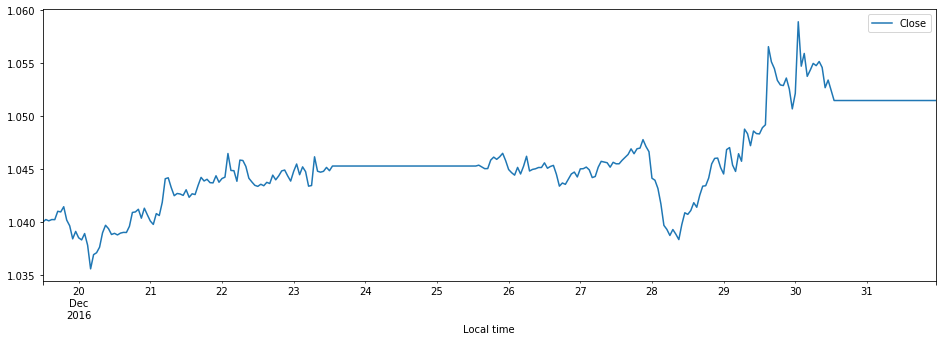

In [94]:
test_data['Close'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [95]:
arima_rmse_error = rmse(test_data['Close'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 4.4471755150633046e-05
RMSE Error: 0.006668714655061577
Mean: 1.1066610668336554


In [97]:
!jupyternotebook --version

/usr/bin/sh: jupyternotebook: command not found


## [Formulate the ML Model](#Model)
- Split input data into [batches](#Batches) (learning windows)
- The Olexander's [moving average model](#MAverage) (TODO)
- Make a standard [ARIMA based model](#ARIMA) (TODO)
    - Explanation of [SARIMAX](#SARIMAX)
- Make a simple [LSTM network](#LSTM) (TODO)
- Combine [LSTM and ARIMA](#LSTM+ARIMA) (TODO)
- Improve the LSTM by applying a [wavelet transformation](#Wavelet) (TODO)

### The Olexander's moving average model<a id='MAverage'></a> (TODO)

### Make a simple LSTM network<a id='LSTM'></a> (TODO)

### Combine LSTM and ARIMA<a id='LSTM+ARIMA'></a> (TODO)
- [Demand Forecasting for Platelet Usage: from Univariate Time Series to Multivariate Models](https://arxiv.org/pdf/2101.02305.pdf)

### Improve the LSTM by applying a wavelet transformation<a id='Wavelet'></a> (TODO)
- A blog about [Wavelets](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/?fbclid=IwAR2w32L-CDuMkAzF5NrmqmsWZu8NHmgW-bt8Em1124AQ58r7AMHam9MQdFU)